In [1]:
# !wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
# !tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
# !mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

'wget' is not recognized as an internal or external command,
operable program or batch file.
tar: Error opening archive: Failed to open 'ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz'
'mv' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
import numpy

In [ ]:
import os
import pathlib
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
# from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline

In [ ]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

      Puts image into numpy array to feed into tensorflow graph.
      Note that by convention we put it into a numpy array with shape
      (height, width, channels), where channels=3 for RGB.

      Args:
        path: a file path.

      Returns:
        uint8 numpy array with shape (img_height, img_width, 3)
    """
    img_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(img_data))
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
          (im_height, im_width, 3)).astype(np.uint8)

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
    """Wrapper function to visualize detections.
    Args:
        image_np: uint8 numpy array with shape (img_height, img_width, 3)
        boxes: a numpy array of shape [N, 4]
        classes: a numpy array of shape [N]. Note that class indices are 1-based,
          and match the keys in the label map.
        scores: a numpy array of shape [N] or None.  If scores=None, then
          this function assumes that the boxes to be plotted are groundtruth
          boxes and plot all boxes as black with no classes or scores.
        category_index: a dict containing category dictionaries (each holding
          category index `id` and category name `name`) keyed by category indices.
        figsize: size for the figure.
        image_name: a name for the image file.
    """
    image_np_with_annotations = image_np.copy()
    viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.8)
    if image_name:
        plt.imsave(image_name, image_np_with_annotations)
    else:
        plt.imshow(image_np_with_annotations)

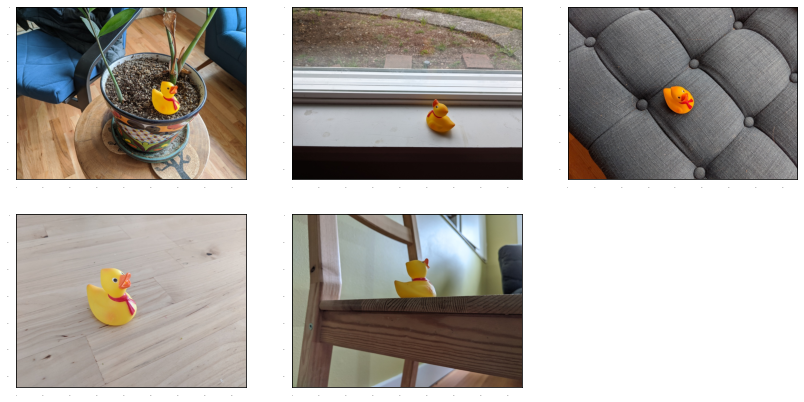

In [8]:
# Load images and visualize
train_image_dir = 'models/research/object_detection/test_images/ducky/train/'
train_images_np = []
for i in range(1, 6):
    image_path = os.path.join(train_image_dir, 'robertducky' + str(i) + '.jpg')
    train_images_np.append(load_image_into_numpy_array(image_path))

plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

for idx, train_image_np in enumerate(train_images_np):
    plt.subplot(2, 3, idx+1)
    plt.imshow(train_image_np)
plt.show()

In [9]:
gt_boxes = [
            np.array([[0.436, 0.591, 0.629, 0.712]], dtype=np.float32),
            np.array([[0.539, 0.583, 0.73, 0.71]], dtype=np.float32),
            np.array([[0.464, 0.414, 0.626, 0.548]], dtype=np.float32),
            np.array([[0.313, 0.308, 0.648, 0.526]], dtype=np.float32),
            np.array([[0.256, 0.444, 0.484, 0.629]], dtype=np.float32)
]

In [10]:
# By convention, our non-background classes start counting at 1.  Given
# that we will be predicting just one class, we will therefore assign it a
# `class id` of 1.
duck_class_id = 1
num_classes = 1

category_index = {duck_class_id: {'id': duck_class_id, 'name': 'rubber_ducky'}}

# Convert class labels to one-hot; convert everything to tensors.
# The `label_id_offset` here shifts all classes by a certain number of indices;
# we do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index.  This is ordinarily just handled
# automatically in our training binaries, but we need to reproduce it here.
label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []
for (train_image_np, gt_box_np) in zip(
    train_images_np, gt_boxes):
    train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(train_image_np, dtype=tf.float32), axis=0))
    gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
    zero_indexed_groundtruth_classes = tf.convert_to_tensor(
        np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
    gt_classes_one_hot_tensors.append(tf.one_hot(zero_indexed_groundtruth_classes, num_classes))
print('Done prepping data.')

Done prepping data.


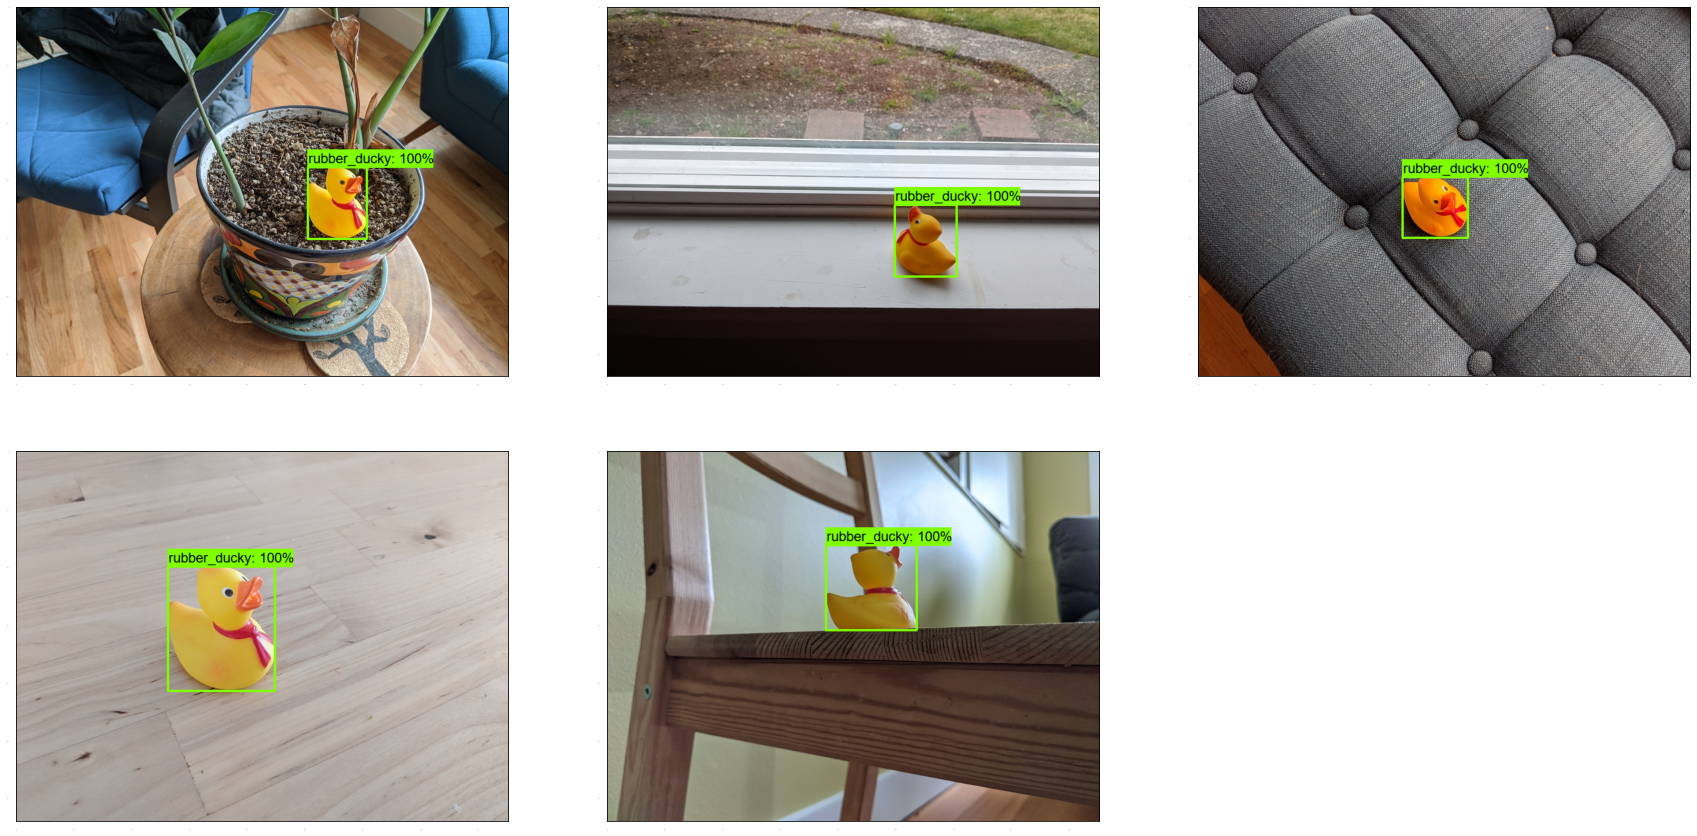

In [12]:
dummy_scores = np.array([1.0], dtype=np.float32)  # give boxes a score of 100%

plt.figure(figsize=(30, 15))
for idx in range(5):
    plt.subplot(2, 3, idx+1)
    plot_detections(
        train_images_np[idx],
        gt_boxes[idx],
        np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),
        dummy_scores, category_index)
plt.show()

In [13]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
num_classes = 1
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'

# Load pipeline config and build a detection model.
#
# Since we are working off of a COCO architecture which predicts 90
# class slots by default, we override the `num_classes` field here to be just
# one (for our new rubber ducky class).
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(model_config=model_config, is_training=True)

# Set up object-based checkpoint restore --- RetinaNet has two prediction
# `heads` --- one for classification, the other for box regression.  We will
# restore the box regression head but initialize the classification head
# from scratch (we show the omission below by commenting out the line that
# we would add if we wanted to restore both heads)
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Building model and restoring weights for fine-tuning...
Weights restored!


In [21]:

# These parameters can be tuned; since our training set has 5 images
# it doesn't make sense to have a much larger batch size, though we could
# fit more examples in memory if we wanted to.
batch_size = 4
learning_rate = 0.01
num_batches = 100

# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
    if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
        to_fine_tune.append(var)

# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
#     """Get a tf.function for training step."""

  # Use tf.function for a bit of speed.
  # Comment out the tf.function decorator if you want the inside of the
  # function to run eagerly.
    @tf.function
    def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
# """A single training iteration.

#     Args:
#       image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
#         Note that the height and width can vary across images, as they are
#         reshaped within this function to be 640x640.
#       groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
#         tf.float32 representing groundtruth boxes for each image in the batch.
#       groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
#         with type tf.float32 representing groundtruth boxes for each image in
#         the batch.

#     Returns:
#       A scalar tensor representing the total loss for the input batch.
# """
        shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
        model.provide_groundtruth(
            groundtruth_boxes_list=groundtruth_boxes_list,
            groundtruth_classes_list=groundtruth_classes_list)
        with tf.GradientTape() as tape:
            preprocessed_images = tf.concat(
                [detection_model.preprocess(image_tensor)[0]
                for image_tensor in image_tensors], axis=0)
            prediction_dict = model.predict(preprocessed_images, shapes)
            losses_dict = model.loss(prediction_dict, shapes)
            total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
            gradients = tape.gradient(total_loss, vars_to_fine_tune)
            optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
        return total_loss
    return train_step_fn

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

print('Start fine-tuning!', flush=True)
for idx in range(num_batches):
    # Grab keys for a random subset of examples
    all_keys = list(range(len(train_images_np)))
    random.shuffle(all_keys)
    example_keys = all_keys[:batch_size]
  # Note that we do not do data augmentation in this demo.  If you want a
  # a fun exercise, we recommend experimenting with random horizontal flipping
  # and random cropping :)
    gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
    gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
    image_tensors = [train_image_tensors[key] for key in example_keys]

  # Training step (forward pass + backwards pass)
    total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

    if idx % 10 == 0:
        print('batch ' + str(idx) + ' of ' + str(num_batches)
            + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

Start fine-tuning!
batch 0 of 100, loss=1.1669657
batch 10 of 100, loss=0.21372959
batch 20 of 100, loss=0.018880464
batch 30 of 100, loss=0.009929387
batch 40 of 100, loss=0.005876259
batch 50 of 100, loss=0.0054188096
batch 60 of 100, loss=0.002935102
batch 70 of 100, loss=0.003271728
batch 80 of 100, loss=0.0027425087
batch 90 of 100, loss=0.002547375
Done fine-tuning!


In [23]:
test_image_dir = 'models/research/object_detection/test_images/ducky/test/'
test_images_np = []
for i in range(1, 50):
    image_path = os.path.join(test_image_dir, 'out' + str(i) + '.jpg')
    test_images_np.append(np.expand_dims(load_image_into_numpy_array(image_path), axis=0))

# Again, uncomment this decorator if you want to run inference eagerly
@tf.function
def detect(input_tensor):
# """Run detection on an input image.

# Args:
#     input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
#     Note that height and width can be anything since the image will be
#     immediately resized according to the needs of the model within this
#     function.

# Returns:
#     A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
#     and `detection_scores`).
# """
    preprocessed_image, shapes = detection_model.preprocess(input_tensor)
    prediction_dict = detection_model.predict(preprocessed_image, shapes)
    return detection_model.postprocess(prediction_dict, shapes)

# Note that the first frame will trigger tracing of the tf.function, which will
# take some time, after which inference should be fast.

label_id_offset = 1
for i in range(len(test_images_np)):
    input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
    detections = detect(input_tensor)

    plot_detections(test_images_np[i][0],
                    detections['detection_boxes'][0].numpy(),
                    detections['detection_classes'][0].numpy().astype(np.uint32)
                    + label_id_offset,
                    detections['detection_scores'][0].numpy(),
                    category_index, figsize=(15, 20), image_name="gif_frame_" + ('%02d' % i) + ".jpg") 